In [ ]:
import cv2

image1 = cv2.imread("image1_60_left.jpg")
image2 = cv2.imread("image1_60_right.jpg")


image_stitching = cv2.Stitcher_create()


In [ ]:
import stitching
from stitching import Stitcher

def plot_image(img, figsize_in_inches=(5,5)):
    fig, ax = plt.subplots(figsize=figsize_in_inches)
    ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()


settings = {"crop": False,"detector": "akaze", "confidence_threshold": 0.2, "warper_type":"plane" }
stitcher = Stitcher(**settings)
stitcher = stitching.Stitcher()
panorama = stitcher.stitch(["image1_60_left.jpg", "image1_60_right.jpg"])
plot_image(panorama, (20,20))

In [1]:
from __future__ import print_function

import argparse
from collections import OrderedDict

import cv2 as cv
import numpy as np
import time
import os

EXPOS_COMP_CHOICES = OrderedDict()
EXPOS_COMP_CHOICES['gain_blocks'] = cv.detail.ExposureCompensator_GAIN_BLOCKS
EXPOS_COMP_CHOICES['gain'] = cv.detail.ExposureCompensator_GAIN
EXPOS_COMP_CHOICES['channel'] = cv.detail.ExposureCompensator_CHANNELS
EXPOS_COMP_CHOICES['channel_blocks'] = cv.detail.ExposureCompensator_CHANNELS_BLOCKS
EXPOS_COMP_CHOICES['no'] = cv.detail.ExposureCompensator_NO

BA_COST_CHOICES = OrderedDict()
BA_COST_CHOICES['ray'] = cv.detail_BundleAdjusterRay
BA_COST_CHOICES['reproj'] = cv.detail_BundleAdjusterReproj
BA_COST_CHOICES['affine'] = cv.detail_BundleAdjusterAffinePartial
BA_COST_CHOICES['no'] = cv.detail_NoBundleAdjuster

FEATURES_FIND_CHOICES = OrderedDict()
try:
    cv.xfeatures2d_SURF.create() # check if the function can be called
    FEATURES_FIND_CHOICES['surf'] = cv.xfeatures2d_SURF.create
except (AttributeError, cv.error) as e:
    print("SURF not available")
# if SURF not available, ORB is default
FEATURES_FIND_CHOICES['orb'] = cv.ORB.create
try:
    FEATURES_FIND_CHOICES['sift'] = cv.SIFT_create
except AttributeError:
    print("SIFT not available")
try:
    FEATURES_FIND_CHOICES['brisk'] = cv.BRISK_create
except AttributeError:
    print("BRISK not available")
try:
    FEATURES_FIND_CHOICES['akaze'] = cv.AKAZE_create
except AttributeError:
    print("AKAZE not available")

SEAM_FIND_CHOICES = OrderedDict()
SEAM_FIND_CHOICES['gc_color'] = cv.detail_GraphCutSeamFinder('COST_COLOR')
SEAM_FIND_CHOICES['gc_colorgrad'] = cv.detail_GraphCutSeamFinder('COST_COLOR_GRAD')
SEAM_FIND_CHOICES['dp_color'] = cv.detail_DpSeamFinder('COLOR')
SEAM_FIND_CHOICES['dp_colorgrad'] = cv.detail_DpSeamFinder('COLOR_GRAD')
SEAM_FIND_CHOICES['voronoi'] = cv.detail.SeamFinder_createDefault(cv.detail.SeamFinder_VORONOI_SEAM)
SEAM_FIND_CHOICES['no'] = cv.detail.SeamFinder_createDefault(cv.detail.SeamFinder_NO)

ESTIMATOR_CHOICES = OrderedDict()
ESTIMATOR_CHOICES['homography'] = cv.detail_HomographyBasedEstimator
ESTIMATOR_CHOICES['affine'] = cv.detail_AffineBasedEstimator

WARP_CHOICES = (
    'spherical',
    'plane',
    'affine',
    'cylindrical',
    'fisheye',
    'stereographic',
    'compressedPlaneA2B1',
    'compressedPlaneA1.5B1',
    'compressedPlanePortraitA2B1',
    'compressedPlanePortraitA1.5B1',
    'paniniA2B1',
    'paniniA1.5B1',
    'paniniPortraitA2B1',
    'paniniPortraitA1.5B1',
    'mercator',
    'transverseMercator',
)

WAVE_CORRECT_CHOICES = OrderedDict()
WAVE_CORRECT_CHOICES['horiz'] = cv.detail.WAVE_CORRECT_HORIZ
WAVE_CORRECT_CHOICES['no'] = None
WAVE_CORRECT_CHOICES['vert'] = cv.detail.WAVE_CORRECT_VERT

BLEND_CHOICES = ('multiband', 'feather', 'no',)



def get_matcher():
    try_cuda = False
    matcher_type = 'homography'
    match_conf = None
    features = 'akaze'
    if match_conf is None:
        if features == 'orb':
            match_conf = 0.3
        else:
            match_conf = 0.65
    else:
        match_conf = match_conf
    range_width = -1
    if matcher_type == "affine":
        matcher = cv.detail_AffineBestOf2NearestMatcher(False, try_cuda, match_conf)
    elif range_width == -1:
        matcher = cv.detail_BestOf2NearestMatcher(try_cuda, match_conf)
    else:
        matcher = cv.detail_BestOf2NearestRangeMatcher(range_width, try_cuda, match_conf)
    return matcher


def get_compensator():
    expos_comp_type = cv.detail.ExposureCompensator_GAIN_BLOCKS
    expos_comp_nr_feeds = 1
    expos_comp_block_size = 32
    # expos_comp_nr_filtering = expos_comp_nr_filtering
    if expos_comp_type == cv.detail.ExposureCompensator_CHANNELS:
        compensator = cv.detail_ChannelsCompensator(expos_comp_nr_feeds)
        # compensator.setNrGainsFilteringIterations(expos_comp_nr_filtering)
    elif expos_comp_type == cv.detail.ExposureCompensator_CHANNELS_BLOCKS:
        compensator = cv.detail_BlocksChannelsCompensator(
            expos_comp_block_size, expos_comp_block_size,
            expos_comp_nr_feeds
        )
        # compensator.setNrGainsFilteringIterations(expos_comp_nr_filtering)
    else:
        compensator = cv.detail.ExposureCompensator_createDefault(expos_comp_type)
    return compensator



def main(index,image1,image2):
    start_count = 0
    time_start=time.time()
    # image1 = cv.imread('image1_60_left.jpg')
    # image2 = cv.imread('image1_60_right.jpg')
    img_names = [image1,image2]
    side_by_side = cv.hconcat([image1,image2])
    # cv.imshow('frame', side_by_side)
    # cv.waitKey(500)
    # cv.destroyAllWindows()

    work_megapix = 2
    seam_megapix = 0.5
    compose_megapix = -1
    conf_thresh = 1.0
    ba_refine_mask = 'xxxxx'
    wave_correct = cv.detail.WAVE_CORRECT_HORIZ
    save_graph = None
    if save_graph is None:
        save_graph = False
    else:
        save_graph = True
    warp_type = 'plane'
    blend_type = 'multiband'
    blend_strength = 5
    result_name = os.path.join(r"C:\Users\User\Documents\machine_learning\yolov7\Video", str(index) + '.jpg')
    timelapse = None
    if timelapse is not None:
        timelapse = True
        if timelapse == "as_is":
            timelapse_type = cv.detail.Timelapser_AS_IS
        elif timelapse == "crop":
            timelapse_type = cv.detail.Timelapser_CROP
        else:
            print("Bad timelapse method")
            exit()
    else:
        timelapse = False
    finder = cv.AKAZE_create()
    seam_work_aspect = 1
    full_img_sizes = []
    features = []
    images = []
    is_work_scale_set = False
    is_seam_scale_set = False
    is_compose_scale_set = False
    # for frame in video_frames:
        
    for name in img_names:
        full_img = name
        if full_img is None:
            print("Cannot read image ", name)
            exit()
        full_img_sizes.append((full_img.shape[1], full_img.shape[0]))
        if work_megapix < 0:
            img = full_img
            work_scale = 1
            is_work_scale_set = True
        else:
            if is_work_scale_set is False:
                work_scale = min(1.0, np.sqrt(work_megapix * 1e6 / (full_img.shape[0] * full_img.shape[1])))
                is_work_scale_set = True
            img = cv.resize(src=full_img, dsize=None, fx=work_scale, fy=work_scale, interpolation=cv.INTER_LINEAR_EXACT)
        if is_seam_scale_set is False:
            if seam_megapix > 0:
                seam_scale = min(1.0, np.sqrt(seam_megapix * 1e6 / (full_img.shape[0] * full_img.shape[1])))
            else:
                seam_scale = 1.0
            seam_work_aspect = seam_scale / work_scale
            is_seam_scale_set = True
        img_feat = cv.detail.computeImageFeatures2(finder, img)
        features.append(img_feat)
        img = cv.resize(src=full_img, dsize=None, fx=seam_scale, fy=seam_scale, interpolation=cv.INTER_LINEAR_EXACT)
        images.append(img)

    matcher = get_matcher()
    p = matcher.apply2(features)
    matcher.collectGarbage()

    if save_graph:
        with open(save_graph, 'w') as fh:
            fh.write(cv.detail.matchesGraphAsString(img_names, p, conf_thresh))

    indices = cv.detail.leaveBiggestComponent(features, p, conf_thresh)
    img_subset = []
    img_names_subset = []
    full_img_sizes_subset = []
    for i in range(len(indices)):
        img_names_subset.append(img_names[indices[i]])
        img_subset.append(images[indices[i]])
        full_img_sizes_subset.append(full_img_sizes[indices[i]])
    images = img_subset
    img_names = img_names_subset
    full_img_sizes = full_img_sizes_subset
    num_images = len(img_names)
    # if num_images < 2:
    #     print("Need more images")
    #     exit()

    estimator = cv.detail_HomographyBasedEstimator()
    b, cameras = estimator.apply(features, p, None)
    if not b:
        print("Homography estimation failed.")
        exit()
    for cam in cameras:
        cam.R = cam.R.astype(np.float32)

    adjuster = cv.detail_BundleAdjusterRay()
    adjuster.setConfThresh(conf_thresh)
    refine_mask = np.zeros((3, 3), np.uint8)
    if ba_refine_mask[0] == 'x':
        refine_mask[0, 0] = 1
    if ba_refine_mask[1] == 'x':
        refine_mask[0, 1] = 1
    if ba_refine_mask[2] == 'x':
        refine_mask[0, 2] = 1
    if ba_refine_mask[3] == 'x':
        refine_mask[1, 1] = 1
    if ba_refine_mask[4] == 'x':
        refine_mask[1, 2] = 1
    adjuster.setRefinementMask(refine_mask)
    b, cameras = adjuster.apply(features, p, cameras)
    if not b:
        print("Camera parameters adjusting failed.")
        exit()
    focals = []
    for cam in cameras:
        focals.append(cam.focal)
    focals.sort()
    if len(focals) % 2 == 1:
        warped_image_scale = focals[len(focals) // 2]
    else:
        warped_image_scale = (focals[len(focals) // 2] + focals[len(focals) // 2 - 1]) / 2
    if wave_correct is not None:
        rmats = []
        for cam in cameras:
            rmats.append(np.copy(cam.R))
        rmats = cv.detail.waveCorrect(rmats, wave_correct)
        for idx, cam in enumerate(cameras):
            cam.R = rmats[idx]
    corners = []
    masks_warped = []
    images_warped = []
    sizes = []
    masks = []
    for i in range(0, num_images):
        um = cv.UMat(255 * np.ones((images[i].shape[0], images[i].shape[1]), np.uint8))
        masks.append(um)

    warper = cv.PyRotationWarper(warp_type, warped_image_scale * seam_work_aspect)  # warper could be nullptr?
    for idx in range(0, num_images):
        K = cameras[idx].K().astype(np.float32)
        swa = seam_work_aspect
        K[0, 0] *= swa
        K[0, 2] *= swa
        K[1, 1] *= swa
        K[1, 2] *= swa
        corner, image_wp = warper.warp(images[idx], K, cameras[idx].R, cv.INTER_LINEAR, cv.BORDER_REFLECT)
        corners.append(corner)
        sizes.append((image_wp.shape[1], image_wp.shape[0]))
        images_warped.append(image_wp)
        p, mask_wp = warper.warp(masks[idx], K, cameras[idx].R, cv.INTER_NEAREST, cv.BORDER_CONSTANT)
        masks_warped.append(mask_wp.get())

    images_warped_f = []
    for img in images_warped:
        imgf = img.astype(np.float32)
        images_warped_f.append(imgf)

    compensator = get_compensator()
    compensator.feed(corners=corners, images=images_warped, masks=masks_warped)

    seam_finder = cv.detail_GraphCutSeamFinder('COST_COLOR')
    masks_warped = seam_finder.find(images_warped_f, corners, masks_warped)
    compose_scale = 1
    corners = []
    sizes = []
    blender = None
    timelapser = None
    # https://github.com/opencv/opencv/blob/4.x/samples/cpp/stitching_detailed.cpp#L725 ?
    for idx, name in enumerate(img_names):
        full_img = cv.imread(name)
        if not is_compose_scale_set:
            if compose_megapix > 0:
                compose_scale = min(1.0, np.sqrt(compose_megapix * 1e6 / (full_img.shape[0] * full_img.shape[1])))
            is_compose_scale_set = True
            compose_work_aspect = compose_scale / work_scale
            warped_image_scale *= compose_work_aspect
            warper = cv.PyRotationWarper(warp_type, warped_image_scale)
            for i in range(0, len(img_names)):
                cameras[i].focal *= compose_work_aspect
                cameras[i].ppx *= compose_work_aspect
                cameras[i].ppy *= compose_work_aspect
                sz = (int(round(full_img_sizes[i][0] * compose_scale)),
                    int(round(full_img_sizes[i][1] * compose_scale)))
                K = cameras[i].K().astype(np.float32)
                roi = warper.warpRoi(sz, K, cameras[i].R)
                corners.append(roi[0:2])
                sizes.append(roi[2:4])
        if abs(compose_scale - 1) > 1e-1:
            img = cv.resize(src=full_img, dsize=None, fx=compose_scale, fy=compose_scale,
                            interpolation=cv.INTER_LINEAR_EXACT)
        else:
            img = full_img
        _img_size = (img.shape[1], img.shape[0])
        K = cameras[idx].K().astype(np.float32)
        corner, image_warped = warper.warp(img, K, cameras[idx].R, cv.INTER_LINEAR, cv.BORDER_REFLECT)
        mask = 255 * np.ones((img.shape[0], img.shape[1]), np.uint8)
        p, mask_warped = warper.warp(mask, K, cameras[idx].R, cv.INTER_NEAREST, cv.BORDER_CONSTANT)
        compensator.apply(idx, corners[idx], image_warped, mask_warped)
        image_warped_s = image_warped.astype(np.int16)
        dilated_mask = cv.dilate(masks_warped[idx], None)
        seam_mask = cv.resize(dilated_mask, (mask_warped.shape[1], mask_warped.shape[0]), 0, 0, cv.INTER_LINEAR_EXACT)
        mask_warped = cv.bitwise_and(seam_mask, mask_warped)
        if blender is None and not timelapse:
            blender = cv.detail.Blender_createDefault(cv.detail.Blender_NO)
            dst_sz = cv.detail.resultRoi(corners=corners, sizes=sizes)
            blend_width = np.sqrt(dst_sz[2] * dst_sz[3]) * blend_strength / 100
            if blend_width < 1:
                blender = cv.detail.Blender_createDefault(cv.detail.Blender_NO)
            elif blend_type == "multiband":
                blender = cv.detail_MultiBandBlender()
                blender.setNumBands((np.log(blend_width) / np.log(2.) - 1.).astype(np.int32))
            elif blend_type == "feather":
                blender = cv.detail_FeatherBlender()
                blender.setSharpness(1. / blend_width)
            blender.prepare(dst_sz)
        elif timelapser is None and timelapse:
            timelapser = cv.detail.Timelapser_createDefault(timelapse_type)
            timelapser.initialize(corners, sizes)
        if timelapse:
            ma_tones = np.ones((image_warped_s.shape[0], image_warped_s.shape[1]), np.uint8)
            timelapser.process(image_warped_s, ma_tones, corners[idx])
            pos_s = img_names[idx].rfind("/")
            if pos_s == -1:
                fixed_file_name = "fixed_" + img_names[idx]
            else:
                fixed_file_name = img_names[idx][:pos_s + 1] + "fixed_" + img_names[idx][pos_s + 1:]
            cv.imwrite(fixed_file_name, timelapser.getDst())
        else:
            blender.feed(cv.UMat(image_warped_s), mask_warped, corners[idx])
    time_finish=time.time()
    if not timelapse:
        result = None
        result_mask = None
        result, result_mask = blender.blend(result, result_mask)
        cv.imwrite(result_name, result)
        zoom_x = 600.0 / result.shape[1]
        dst = cv.normalize(src=result, dst=None, alpha=255., norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
        dst = cv.resize(dst, dsize=None, fx=zoom_x, fy=zoom_x)
        cv.imshow(result_name, dst)
        cv.waitKey()
    
    
    print(time_finish-time_start)
    print("Done")


if __name__ == '__main__':
    # video1 = cv.VideoCapture('Video1.mp4')
    # video2 = cv.VideoCapture('Video2.mp4')
    # frame_count1 = int(video1.get(cv.CAP_PROP_FRAME_COUNT))
    # frame_count2 = int(video2.get(cv.CAP_PROP_FRAME_COUNT))
    # frame_count_list = [frame_count1, frame_count2]
    # ret1 = video1.grab()
    # ret2 = video2.grab()
    # for i in range(min(frame_count_list)):
    #     frame_index = int(video1.get(cv.CAP_PROP_POS_FRAMES))
    #     print(frame_index)
    #     _,frame1 = video1.retrieve()
    #     _,frame2 = video2.retrieve()
        
    #     main(i, frame1,frame2)
    #     frame1 = video1.grab()
    #     frame2 = video2.grab()
    image1 = cv.imread('image1_60_left.jpg')
    image2 = cv.imread('image1_60_right.jpg')
    main(1,image1,image2)
        
    cv.destroyAllWindows()

SURF not available


error: OpenCV(4.8.0) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/compat_ptsetreg.cpp:125: error: (-215:Assertion failed) !err.empty() in function 'update'


In [8]:
image1=cv.imread('50_intersect_left.jpg')
image2=cv.imread('50_intersect_right.jpg')
print(image1.shape)
print(image2.shape)

(720, 512, 3)
(720, 512, 3)


In [3]:
import cv2 as cv
import os
def open_image(index, image1,image2):
    # image1 = cv.imread(image1)
    # image2 = cv.imread(image2)
    # image1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY )
    # image2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY )
    cv.imwrite(os.path.join(r'C:\Users\User\Documents\machine_learning\yolov7\Video', 'frame1.jpg'.format(index)), frame1)
    cv.imwrite(os.path.join(r'C:\Users\User\Documents\machine_learning\yolov7\Video', 'frame2.jpg'.format(index)), frame2)
    side_by_side = cv.hconcat([frame1, frame2])
    cv.imshow('frame', side_by_side)
    
    cv.waitKey(500)
    cv.destroyAllWindows()

if __name__ == '__main__':
    video1 = cv.VideoCapture('Video1.mp4')
    video2 = cv.VideoCapture('Video2.mp4')
    frame_count1 = int(video1.get(cv.CAP_PROP_FRAME_COUNT))
    frame_count2 = int(video2.get(cv.CAP_PROP_FRAME_COUNT))
    print(frame_count1, frame_count2)
    frame_count_list = [frame_count1, frame_count2]
    print(min(frame_count_list))
    print(video1.getBackendName())
    ret1 = video1.grab()
    ret2 = video2.grab()
    for i in range(10):
        frame_index = int(video1.get(cv.CAP_PROP_POS_FRAMES))
        print(frame_index)
        _,frame1 = video1.retrieve()
        _,frame2 = video2.retrieve()
        
        open_image(i, frame1,frame2)
        frame1 = video1.grab()
        frame2 = video2.grab()
    
    cv.destroyAllWindows()

1814 1814
1814
FFMPEG
1
2
3
4
5
6
7
8
9
10


In [14]:
import cv2

image1 = cv2.imread("image1_60_left.jpg")
image2 = cv2.imread("image1_60_right.jpg")
print(image1.shape)
print(image2.shape)
side_by_side = cv2.hconcat([image1, image2])
cv2.namedWindow("Resized_Window", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Resized_Window", 1920, 1080)
cv2.imshow("Resized_Window", side_by_side)
cv2.waitKey(10000)
cv2.destroyAllWindows()

(1536, 1228, 3)
(1536, 1228, 3)


KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np 


cap1 = cv2.VideoCapture('Video1.mp4')
cap2 = cv2.VideoCapture('Video2.mp4')
while cap1.isOpened() or cap2.isOpened():

    okay1  , frame1 = cap1.read()
    okay2 , frame2 = cap2.read()
    print(frame1.shape)
    print(frame2.shape)
    
    if okay1 and okay2:
        side_by_side = cv2.hconcat([frame1, frame2])
        cv2.namedWindow("Resized_Window", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("Resized_Window", 1920, 1080)
        cv2.imshow("Resized_Window", side_by_side)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    # if okay1:
    #     # hsv1 = cv2.cvtColor(frame1 , cv2.COLOR_BGR2GRAY)
    #     cv2.imshow('fake' , frame1)

    # if okay2:
    #     # hsv2 = cv2.cvtColor(frame2 , cv2.COLOR_BGR2GRAY)
    #     cv2.imshow('real' , frame2)

    # if not okay1 or not okay2:
    #     print('Cant read the video , Exit!')
    #     break

    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break
    
    cv2.waitKey(1)

cap1.release()
cap2.release()
cv2.destroyAllWindows()

(720, 512, 3)
(720, 512, 3)


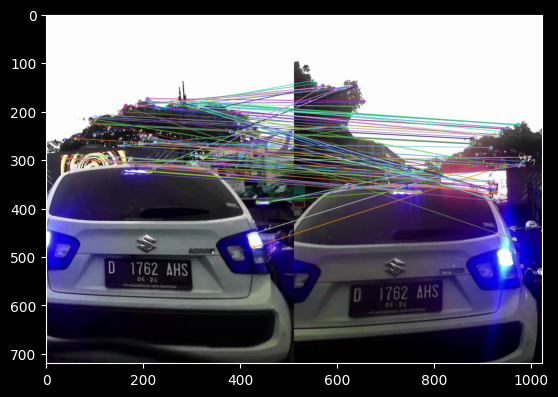

0.018980979919433594


In [8]:


import cv2
import matplotlib.pyplot as plt
import time
image1= cv2.imread("50_intersect_left.jpg", flags=cv2.IMREAD_COLOR)
image2= cv2.imread("50_intersect_right.jpg",flags=cv2.IMREAD_COLOR)
print(image1.shape)
print(image2.shape)
BRISK = cv2.ORB_create()
time_start=time.time()

keypoints1, descriptors1 = BRISK.detectAndCompute(image1, None)
keypoints2, descriptors2 = BRISK.detectAndCompute(image2, None)

# create BFMatcher object
BFMatcher = cv2.BFMatcher(normType = cv2.NORM_HAMMING,
                         crossCheck = True)

# # Matching descriptor vectors using Brute Force Matcher
matches = BFMatcher.match(queryDescriptors = descriptors1,
                          trainDescriptors = descriptors2)
time_end=time.time()
# Sort them in the order of their distance
matches = sorted(matches, key = lambda x: x.distance)

# Draw first 15 matches
output = cv2.drawMatches(img1 = image1,
                        keypoints1 = keypoints1,
                        img2 = image2,
                        keypoints2 = keypoints2,
                        matches1to2 = matches[:100],
                        outImg = None,
                        flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


plt.imshow(output)
# plt.savefig("BRISK_Video.jpg")
plt.show()
print(time_end-time_start)


In [ ]:
import cv2
for file in os.listdir(r"C:\Users\User\Documents\machine_learning\yolov7\Video"):
    print(file)
    # frame = cv2.imread(file)
    # cv2.imshow("frame",frame)
    # if cv2.waitKey(0) & 0xFF == ord('q'):
    #     break
    # cv2.destroyAllWindows()   

# #     cap = cv2.VideoCapture(input_loc)


In [ ]:
import cv2 as cv
import numpy as np


def FindHomography(Matches, BaseImage_kp, SecImage_kp):
    # If less than 4 matches found, exit the code.
    if len(Matches) < 4:
        print("\nNot enough matches found between the images.\n")
        exit(0)

    # Storing coordinates of points corresponding to the matches found in both the images
    BaseImage_pts = []
    SecImage_pts = []
    for Match in Matches:
        BaseImage_pts.append(BaseImage_kp[Match[0].queryIdx].pt)
        SecImage_pts.append(SecImage_kp[Match[0].trainIdx].pt)

    # Changing the datatype to "float32" for finding homography
    BaseImage_pts = np.float32(BaseImage_pts)
    SecImage_pts = np.float32(SecImage_pts)

    # Finding the homography matrix(transformation matrix).
    (HomographyMatrix, Status) = cv.findHomography(SecImage_pts, BaseImage_pts, cv.RANSAC, 4.0)

    return HomographyMatrix, Status


def GetNewFrameSizeAndMatrix(HomographyMatrix, Sec_ImageShape, Base_ImageShape):
    # Reading the size of the image
    (Height, Width) = Sec_ImageShape

    # Taking the matrix of initial coordinates of the corners of the secondary image
    # Stored in the following format: [[x1, x2, x3, x4], [y1, y2, y3, y4], [1, 1, 1, 1]]
    # Where (xi, yi) is the coordinate of the i th corner of the image.
    InitialMatrix = np.array([[0, Width - 1, Width - 1, 0],
                              [0, 0, Height - 1, Height - 1],
                              [1, 1, 1, 1]])

    # Finding the final coordinates of the corners of the image after transformation.
    # NOTE: Here, the coordinates of the corners of the frame may go out of the
    # frame(negative values). We will correct this afterwards by updating the
    # homography matrix accordingly.
    FinalMatrix = np.dot(HomographyMatrix, InitialMatrix)

    [x, y, c] = FinalMatrix
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the stitched image frame and the "Correction" factor
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    New_Width = max_x
    New_Height = max_y
    Correction = [0, 0]
    if min_x < 0:
        New_Width -= min_x
        Correction[0] = abs(min_x)
    if min_y < 0:
        New_Height -= min_y
        Correction[1] = abs(min_y)

    # Again correcting New_Width and New_Height
    # Helpful when secondary image is overlaped on the left hand side of the Base image.
    if New_Width < Base_ImageShape[1] + Correction[0]:
        New_Width = Base_ImageShape[1] + Correction[0]
    if New_Height < Base_ImageShape[0] + Correction[1]:
        New_Height = Base_ImageShape[0] + Correction[1]

    # Finding the coordinates of the corners of the image if they all were within the frame.
    x = np.add(x, Correction[0])
    y = np.add(y, Correction[1])
    OldInitialPoints = np.float32([[0, 0],
                                   [Width - 1, 0],
                                   [Width - 1, Height - 1],
                                   [0, Height - 1]])
    NewFinalPonts = np.float32(np.array([x, y]).transpose())

    # Updating the homography matrix. Done so that now the secondary image completely
    # lies inside the frame
    HomographyMatrix = cv.getPerspectiveTransform(OldInitialPoints, NewFinalPonts)

    return [New_Height, New_Width], Correction, HomographyMatrix


ratio_thresh = 0.9

image1 = cv.imread('frame1_kiri.jpg')

image2 = cv.imread('frame2_kanan.jpg')



# -----------------------------------------KAZE--------------------------------#

AKAZE = cv.AKAZE_create()  # KAZE, AKAZE, ORB, BRISK, xfeatures2d.SURF

keypoints1, descriptors1 = AKAZE.detectAndCompute(image1, None)
keypoints2, descriptors2 = AKAZE.detectAndCompute(image2, None)

FLANN_INDEX_KDTREE = 1

index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

descriptors1 = np.float32(descriptors1)
descriptors2 = np.float32(descriptors2)

FLANN = cv.FlannBasedMatcher(indexParams=index_params,
                             searchParams=search_params)

matches = FLANN.knnMatch(queryDescriptors=descriptors1,
                         trainDescriptors=descriptors2,
                         k=2)

good_matches = []
t = []
for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append([m])
        t.append(m)

output = cv.drawMatches(img1=image1,
                        keypoints1=keypoints1,
                        img2=image2,
                        keypoints2=keypoints2,
                        matches1to2=t,
                        outImg=None,
                        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

cv.namedWindow("drawMatches.jpg")
cv.imshow("drawMatches.jpg", output)

# ----------------------------------FindHomography-------------------------------------------#

HomographyMatrix, Status = FindHomography(good_matches, keypoints1, keypoints2)

BaseImage = image1
SecImage = image2

NewFrameSize, Correction, HomographyMatrix = GetNewFrameSizeAndMatrix(HomographyMatrix, SecImage.shape[:2],
                                                                      BaseImage.shape[:2])

StitchedImage = cv.warpPerspective(SecImage, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
StitchedImage[Correction[1]:Correction[1] + BaseImage.shape[0],
Correction[0]:Correction[0] + BaseImage.shape[1]] = BaseImage

cv.namedWindow("stitched2.jpg")
cv.imshow("stitched2.jpg", StitchedImage)


cv.imwrite("result.jpg", StitchedImage)
while True:
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
